In [1]:
import os
import time
import requests
import requests_cache

import numpy as np
import pandas as pd
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

True

## GitHub User Data Scraping

### Testing GH Search API

In [2]:
url = "https://api.github.com/search/users"

params = {
    'q': 'followers:>100 location:Toronto',  # Uses a query string (GraphQL).
    'per_page': 100,
    'page': 1
}
# Authenticated Users: 5,000 requests per hour.
access_token = os.getenv('GITHUB_TOKEN')
headers = {'Authorization': f'token {access_token}'}

response = requests.get(url, params=params, headers=headers)
print('URL:', response.url)

if response.status_code == 200:
    data = response.json()
    print('# users:', len(data['items']))
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

URL: https://api.github.com/search/users?q=followers%3A%3E100+location%3AToronto&per_page=100&page=1
# users: 100


In [3]:
response.links  # feature of requests library

{'next': {'url': 'https://api.github.com/search/users?q=followers%3A%3E100+location%3AToronto&per_page=100&page=2',
  'rel': 'next'},
 'last': {'url': 'https://api.github.com/search/users?q=followers%3A%3E100+location%3AToronto&per_page=100&page=7',
  'rel': 'last'}}

In [4]:
data.keys()

dict_keys(['total_count', 'incomplete_results', 'items'])

In [5]:
data['items'][0]

{'login': 'aneagoie',
 'id': 10776230,
 'node_id': 'MDQ6VXNlcjEwNzc2MjMw',
 'avatar_url': 'https://avatars.githubusercontent.com/u/10776230?v=4',
 'gravatar_id': '',
 'url': 'https://api.github.com/users/aneagoie',
 'html_url': 'https://github.com/aneagoie',
 'followers_url': 'https://api.github.com/users/aneagoie/followers',
 'following_url': 'https://api.github.com/users/aneagoie/following{/other_user}',
 'gists_url': 'https://api.github.com/users/aneagoie/gists{/gist_id}',
 'starred_url': 'https://api.github.com/users/aneagoie/starred{/owner}{/repo}',
 'subscriptions_url': 'https://api.github.com/users/aneagoie/subscriptions',
 'organizations_url': 'https://api.github.com/users/aneagoie/orgs',
 'repos_url': 'https://api.github.com/users/aneagoie/repos',
 'events_url': 'https://api.github.com/users/aneagoie/events{/privacy}',
 'received_events_url': 'https://api.github.com/users/aneagoie/received_events',
 'type': 'User',
 'user_view_type': 'public',
 'site_admin': False,
 'score': 1

### Search for Users

* Toronto users with more than 100 followers

In [6]:
def dynamic_delay(response):
    if response.headers.get('X-RateLimit-Remaining') == '0':
        reset_time = int(response.headers.get('X-RateLimit-Reset'))
        sleep_time = reset_time - int(time.time()) + 5  # Add a buffer of 5s.

        print(f"Rate limit exceeded. Sleeping for {sleep_time} seconds!")
        time.sleep(sleep_time)

    time.sleep(1)  # Sleep for 1s regardless.

In [7]:
printed_message_from_cached = False
requests_cache.install_cache('cache/search_users', expire_after=None)

users = []  # All users in Toronto with more than 100 followers.

url = "https://api.github.com/search/users"
params = {
    'q': 'followers:>100 location:Toronto',  # Uses a query string (GraphQL).
    'per_page': 100,
    'page': 1
}

access_token = os.getenv('GITHUB_TOKEN')
headers = {'Authorization': f'token {access_token}'}

while True:
    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch users. Status code: {response.status_code}")
        break

    data = response.json()

    for user in data.get('items', []):
        users.append({
            'login': user['login'],
            'id': user['id'],
            'url': user['url'],
            'repos_url': user['repos_url']
        })
    
    if response.from_cache:
        if not printed_message_from_cached:
            print('Fetched from cache.')
            printed_message_from_cached = True
    else:
        print("Fetched from API:", response.url)
        dynamic_delay(response)

    # Check if there are more pages.
    if 'next' not in response.links:
        break

    params['page'] += 1

print('# of users:', len(users))

Fetched from cache.
# of users: 680


In [8]:
dict(response.headers)

{'Access-Control-Allow-Origin': '*',
 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Resource, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, X-GitHub-SSO, X-GitHub-Request-Id, Deprecation, Sunset',
 'Cache-Control': 'no-cache',
 'Content-Encoding': 'gzip',
 'Content-Security-Policy': "default-src 'none'",
 'Content-Type': 'application/json; charset=utf-8',
 'Date': 'Mon, 21 Oct 2024 16:43:35 GMT',
 'Link': '<https://api.github.com/search/users?q=followers%3A%3E100+location%3AToronto&per_page=100&page=6>; rel="prev", <https://api.github.com/search/users?q=followers%3A%3E100+location%3AToronto&per_page=100&page=1>; rel="first"',
 'Referrer-Policy': 'origin-when-cross-origin, strict-origin-when-cross-origin',
 'Server': 'github.com',
 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload',
 'Transfer-Encoding':

In [9]:
users[0]

{'login': 'aneagoie',
 'id': 10776230,
 'url': 'https://api.github.com/users/aneagoie',
 'repos_url': 'https://api.github.com/users/aneagoie/repos'}

### Fetch User Data

In [10]:
def clean_company_name(company):
    company_name = None
    if company:
        company_name = company.strip()
        if company_name.startswith('@'):
            company_name = company_name[1:]
        company_name = company_name.upper()
    
    return company_name

In [11]:
printed_message_from_cached = False
requests_cache.install_cache('cache/users', expire_after=None)

users_data = []

for user in users:
    response = requests.get(user['url'], headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch {user['login']}'s data. Status code: {response.status_code}")
        break
    
    data = response.json()
    
    users_data.append({
        'login': data['login'],
        'name': data['name'] or '',
        'company': clean_company_name(data['company']) or '',
        'location': data['location'] or '',
        'email': data['email'] or '',
        'hireable': data['hireable'] or False,
        'bio': data['bio'] or '',
        'public_repos': data['public_repos'],
        'followers': data['followers'],
        'following': data['following'],
        'created_at': data['created_at'],
    })

    if response.from_cache:
        if not printed_message_from_cached:
            print('Fetched from cache.')
            printed_message_from_cached = True
    else:
        print('Fetched from API:', response.url)
        dynamic_delay(response)

users_data[0]

Fetched from cache.


{'login': 'aneagoie',
 'name': 'Andrei Neagoie',
 'company': '',
 'location': 'Toronto, Canada',
 'email': '',
 'hireable': True,
 'bio': 'Senior Software Dev turned Instructor. Founder of zerotomastery.io',
 'public_repos': 145,
 'followers': 10268,
 'following': 1,
 'created_at': '2015-01-30T17:05:43Z'}

In [12]:
len(users_data)

680

In [13]:
dict(response.headers)

{'Access-Control-Allow-Origin': '*',
 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Resource, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, X-GitHub-SSO, X-GitHub-Request-Id, Deprecation, Sunset',
 'Cache-Control': 'private, max-age=60, s-maxage=60',
 'Content-Encoding': 'gzip',
 'Content-Security-Policy': "default-src 'none'",
 'Content-Type': 'application/json; charset=utf-8',
 'Date': 'Mon, 21 Oct 2024 17:01:38 GMT',
 'ETag': 'W/"dbbd1c8be0f168814915dde0d8fbc5b716d3913a61c224d395043082b7f75e8b"',
 'Last-Modified': 'Fri, 18 Oct 2024 22:22:40 GMT',
 'Referrer-Policy': 'origin-when-cross-origin, strict-origin-when-cross-origin',
 'Server': 'github.com',
 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload',
 'Transfer-Encoding': 'chunked',
 'Vary': 'Accept, Authorization, Cookie, X-GitHub-OTP,Accept-Encod

#### Save user data to .csv

In [14]:
users_df = pd.DataFrame(users_data)
users_df.head()

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at
0,aneagoie,Andrei Neagoie,,"Toronto, Canada",,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30T17:05:43Z
1,ZhangMYihua,Yihua Zhang,,Toronto,yihuazhang2@gmail.com,False,Toronto Software Developer,143,5804,11,2015-01-18T00:01:02Z
2,susanli2016,Susan Li,,Toronto Canada,,False,Chief Data Scientist,34,4917,68,2016-11-28T04:22:39Z
3,thedaviddias,David Dias,KIJIJICA,"Toronto, Canada",,False,💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...,89,4533,301,2010-04-05T14:40:12Z
4,ange-yaghi,Ange Yaghi,,Toronto,me@angeyaghi.com,False,C++ Developer,32,4020,11,2016-07-13T21:01:21Z


In [15]:
total_number_of_repos_expected = users_df[users_df['public_repos'] <= 500]['public_repos'].sum() + (500 * len(users_df[users_df['public_repos'] > 500]))
print(f"Total Expected Repos: {total_number_of_repos_expected}")

Total Expected Repos: 54875


In [16]:
n_unique_users = len(users_df['login'].unique())  # Sanity check.
print(f"# of unique users: {n_unique_users}")

# of unique users: 680


In [17]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   login         680 non-null    object
 1   name          680 non-null    object
 2   company       680 non-null    object
 3   location      680 non-null    object
 4   email         680 non-null    object
 5   hireable      680 non-null    bool  
 6   bio           680 non-null    object
 7   public_repos  680 non-null    int64 
 8   followers     680 non-null    int64 
 9   following     680 non-null    int64 
 10  created_at    680 non-null    object
dtypes: bool(1), int64(3), object(7)
memory usage: 53.9+ KB


In [18]:
users_df['hireable'] = users_df['hireable'].replace({True: 'true', False: 'false'})

In [19]:
users_df.to_csv('users.csv', index=False)

### Fetch Users' Repo Data

In [20]:
printed_message_from_cached = False
requests_cache.install_cache('cache/repos', expire_after=None)

repos_data = []

for user in users:
    repos = []
    params = {
        'sort': 'pushed',
        'direction': 'desc',
        'per_page': 100,
        'page': 1,
    }
    while True:
        response = requests.get(user['repos_url'], params=params, headers=headers)

        if response.status_code != 200:
            print(f"Failed to fetch { user['login'] }'s repo data. Status code: {response.status_code}")
            break
        
        data = response.json()
        for repo in data:
            repos.append({
                'login': user['login'],
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'] or '',
                'has_projects': repo['has_projects'],
                'has_wiki': repo['has_wiki'],
                'license_name': repo['license']['key'] if repo['license'] else '',
            })
        
        if response.from_cache:
            if not printed_message_from_cached:
                print('Fetched from cache.')
                printed_message_from_cached = True
        else:
            print('Fetched from API:', response.url)
            dynamic_delay(response)

        if ('next' not in response.links) or (params['page'] == 5):
            break

        params['page'] += 1
    
    repos_data.extend(repos)

print('# of Repos:', len(repos_data))

Fetched from cache.
# of Repos: 54875


In [21]:
print('Pass repos sanity check:', total_number_of_repos_expected == len(repos_data))

Pass repos sanity check: True


In [22]:
repos_data[1]

{'login': 'aneagoie',
 'full_name': 'aneagoie/ML-Notes',
 'created_at': '2019-09-28T02:31:10Z',
 'stargazers_count': 60,
 'watchers_count': 60,
 'language': 'Jupyter Notebook',
 'has_projects': True,
 'has_wiki': True,
 'license_name': ''}

#### Save repo data to .csv

In [23]:
repos_df = pd.DataFrame(repos_data)
repos_df.head()

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,aneagoie,aneagoie/ztm-extension,2023-12-15T13:32:57Z,3,3,JavaScript,True,False,mit
1,aneagoie,aneagoie/ML-Notes,2019-09-28T02:31:10Z,60,60,Jupyter Notebook,True,True,
2,aneagoie,aneagoie/smart-brain-boost-api-dockerized,2018-04-12T18:44:49Z,55,55,JavaScript,True,True,
3,aneagoie,aneagoie/smart-brain-boost-api,2018-04-09T18:46:06Z,14,14,JavaScript,True,True,
4,aneagoie,aneagoie/smart-brain-boost-lambda,2018-04-15T17:02:27Z,20,20,JavaScript,True,True,


In [24]:
repos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54875 entries, 0 to 54874
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   login             54875 non-null  object
 1   full_name         54875 non-null  object
 2   created_at        54875 non-null  object
 3   stargazers_count  54875 non-null  int64 
 4   watchers_count    54875 non-null  int64 
 5   language          54875 non-null  object
 6   has_projects      54875 non-null  bool  
 7   has_wiki          54875 non-null  bool  
 8   license_name      54875 non-null  object
dtypes: bool(2), int64(2), object(5)
memory usage: 3.0+ MB


In [25]:
repos_df['has_projects'] = repos_df['has_projects'].replace({True: 'true', False: 'false'})
repos_df['has_wiki'] = repos_df['has_wiki'].replace({True: 'true', False: 'false'})

In [26]:
repos_df.to_csv('repositories.csv', index=False)

## Questions

In [27]:
users_df = pd.read_csv('users.csv')
repos_df = pd.read_csv('repositories.csv')

In [28]:
users_df.head()

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at
0,aneagoie,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30T17:05:43Z
1,ZhangMYihua,Yihua Zhang,NaN,Toronto,yihuazhang2@gmail.com,False,Toronto Software Developer,143,5804,11,2015-01-18T00:01:02Z
2,susanli2016,Susan Li,NaN,Toronto Canada,NaN,False,Chief Data Scientist,34,4917,68,2016-11-28T04:22:39Z
3,thedaviddias,David Dias,KIJIJICA,"Toronto, Canada",NaN,False,💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...,89,4533,301,2010-04-05T14:40:12Z
4,ange-yaghi,Ange Yaghi,NaN,Toronto,me@angeyaghi.com,False,C++ Developer,32,4020,11,2016-07-13T21:01:21Z


In [29]:
repos_df.head()

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,aneagoie,aneagoie/ztm-extension,2023-12-15T13:32:57Z,3,3,JavaScript,True,False,mit
1,aneagoie,aneagoie/ML-Notes,2019-09-28T02:31:10Z,60,60,Jupyter Notebook,True,True,NaN
2,aneagoie,aneagoie/smart-brain-boost-api-dockerized,2018-04-12T18:44:49Z,55,55,JavaScript,True,True,NaN
3,aneagoie,aneagoie/smart-brain-boost-api,2018-04-09T18:46:06Z,14,14,JavaScript,True,True,NaN
4,aneagoie,aneagoie/smart-brain-boost-lambda,2018-04-15T17:02:27Z,20,20,JavaScript,True,True,NaN


Q1. Who are the top 5 users in Toronto with the highest number of followers? List their login in order, comma-separated.

In [30]:
users_df.nlargest(n=5, columns='followers')[['login', 'followers']]

,login,followers
0,aneagoie,10268
1,ZhangMYihua,5804
2,susanli2016,4917
3,thedaviddias,4533
4,ange-yaghi,4020


In [31]:
','.join(users_df.nlargest(n=5, columns='followers')['login'].to_list())

'aneagoie,ZhangMYihua,susanli2016,thedaviddias,ange-yaghi'

Q2. Who are the 5 earliest registered GitHub users in Toronto? List their login in ascending order of created_at, comma-separated.

In [32]:
users_df['created_at'] = pd.to_datetime(users_df['created_at'])
users_df.head()

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at
0,aneagoie,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00
1,ZhangMYihua,Yihua Zhang,NaN,Toronto,yihuazhang2@gmail.com,False,Toronto Software Developer,143,5804,11,2015-01-18 00:01:02+00:00
2,susanli2016,Susan Li,NaN,Toronto Canada,NaN,False,Chief Data Scientist,34,4917,68,2016-11-28 04:22:39+00:00
3,thedaviddias,David Dias,KIJIJICA,"Toronto, Canada",NaN,False,💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...,89,4533,301,2010-04-05 14:40:12+00:00
4,ange-yaghi,Ange Yaghi,NaN,Toronto,me@angeyaghi.com,False,C++ Developer,32,4020,11,2016-07-13 21:01:21+00:00


In [33]:
users_df.iloc[users_df['created_at'].sort_values(ascending=True).index[:5].to_list()][['login', 'created_at']]

,login,created_at
428,jamesmacaulay,2008-02-17 20:11:15+00:00
21,michaelklishin,2008-02-27 16:49:40+00:00
522,myles,2008-02-27 22:49:45+00:00
575,nwjsmith,2008-02-28 00:38:55+00:00
78,vito,2008-03-01 18:39:55+00:00


In [34]:
oldest_users = users_df.iloc[users_df['created_at'].sort_values(ascending=True).index[:5].to_list()]['login'].to_list()
','.join(sorted(oldest_users))

'jamesmacaulay,michaelklishin,myles,nwjsmith,vito'

Q3. What are the 3 most popular license among these users? Ignore missing licenses. List the license_name in order, comma-separated.

In [35]:
repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])
repos_df.head()

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,aneagoie,aneagoie/ztm-extension,2023-12-15 13:32:57+00:00,3,3,JavaScript,True,False,mit
1,aneagoie,aneagoie/ML-Notes,2019-09-28 02:31:10+00:00,60,60,Jupyter Notebook,True,True,NaN
2,aneagoie,aneagoie/smart-brain-boost-api-dockerized,2018-04-12 18:44:49+00:00,55,55,JavaScript,True,True,NaN
3,aneagoie,aneagoie/smart-brain-boost-api,2018-04-09 18:46:06+00:00,14,14,JavaScript,True,True,NaN
4,aneagoie,aneagoie/smart-brain-boost-lambda,2018-04-15 17:02:27+00:00,20,20,JavaScript,True,True,NaN


In [36]:
repos_df['license_name'].value_counts(dropna=True)[:3]

license_name
mit           13343
other          4221
apache-2.0     4061
Name: count, dtype: int64

In [37]:
','.join(repos_df['license_name'].value_counts(dropna=True).index[:3].to_list())

'mit,other,apache-2.0'

In [38]:
repos_df['license_name'].isna().sum()

np.int64(27297)

Q4. Which company do the majority of these developers work at?

In [39]:
users_df['company'].value_counts()[:5]

company
UNIVERSITY OF TORONTO    21
SHOPIFY                  16
NVIDIA                    7
GOOGLE                    6
YORK UNIVERSITY           5
Name: count, dtype: int64

In [40]:
users_df['company'].value_counts().index[0]

'UNIVERSITY OF TORONTO'

Q5. Which programming language is most popular among these users?

In [41]:
repos_df['language'].value_counts()[:5]

language
JavaScript    10654
Python         5029
TypeScript     2228
Java           2104
Ruby           2101
Name: count, dtype: int64

In [42]:
repos_df['language'].value_counts().index[0]

'JavaScript'

Q6. Which programming language is the second most popular among users who joined after 2020?

In [43]:
pd.merge?

Signature:
pd.merge(
    left: 'DataFrame | Series',
    right: 'DataFrame | Series',
    how: 'MergeHow' = 'inner',
    on: 'IndexLabel | AnyArrayLike | None' = None,
    left_on: 'IndexLabel | AnyArrayLike | None' = None,
    right_on: 'IndexLabel | AnyArrayLike | None' = None,
    left_index: 'bool' = False,
    right_index: 'bool' = False,
    sort: 'bool' = False,
    suffixes: 'Suffixes' = ('_x', '_y'),
    copy: 'bool | None' = None,
    indicator: 'str | bool' = False,
    validate: 'str | None' = None,
) -> 'DataFrame'
Docstring:
Merge DataFrame or named Series objects with a database-style join.

A named Series object is treated as a DataFrame with a single named column.

The join is done on columns or indexes. If joining columns on
columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
on indexes or indexes on a column or columns, the index will be passed on.
When performing a cross merge, no column specifications to merge on are
allowed.

.. warning:

In [44]:
merged = repos_df.merge(users_df, how='inner', on='login', suffixes=('_repo', '_user'))
merged.head()

,login,full_name,created_at_repo,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name,name,company,location,email,hireable,bio,public_repos,followers,following,created_at_user
0,aneagoie,aneagoie/ztm-extension,2023-12-15 13:32:57+00:00,3,3,JavaScript,True,False,mit,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00
1,aneagoie,aneagoie/ML-Notes,2019-09-28 02:31:10+00:00,60,60,Jupyter Notebook,True,True,NaN,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00
2,aneagoie,aneagoie/smart-brain-boost-api-dockerized,2018-04-12 18:44:49+00:00,55,55,JavaScript,True,True,NaN,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00
3,aneagoie,aneagoie/smart-brain-boost-api,2018-04-09 18:46:06+00:00,14,14,JavaScript,True,True,NaN,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00
4,aneagoie,aneagoie/smart-brain-boost-lambda,2018-04-15 17:02:27+00:00,20,20,JavaScript,True,True,NaN,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00


In [45]:
users_df[users_df['created_at'].dt.year > 2020]['public_repos'].sum()

np.int64(640)

In [46]:
merged[merged['created_at_user'].dt.year > 2020]['language'].value_counts()[:5]

language
JavaScript    151
TypeScript     48
HTML           42
CSS            31
Python         30
Name: count, dtype: int64

In [47]:
merged[merged['created_at_user'].dt.year > 2020]['language'].value_counts().index[1]

'TypeScript'

Q7. Which language has the highest average number of stars per repository?

In [48]:
repos_df.groupby('language')['stargazers_count'].mean().sort_values(ascending=False)[:5]

language
Cython            1778.0
Forth             1183.0
ASP.NET            414.0
BrighterScript     311.0
SAS                172.0
Name: stargazers_count, dtype: float64

In [49]:
repos_df.groupby('language')['stargazers_count'].mean().sort_values(ascending=False).index[0]

'Cython'

Q8. Let's define `leader_strength` as `followers / (1 + following)`. Who are the top 5 in terms of `leader_strength`? List their login in order, comma-separated.

In [50]:
users_df['leader_strength'] = users_df['followers'] / (1 + users_df['following'])
users_df.head()

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at,leader_strength
0,aneagoie,Andrei Neagoie,NaN,"Toronto, Canada",NaN,True,Senior Software Dev turned Instructor. Founder...,145,10268,1,2015-01-30 17:05:43+00:00,5134.000000
1,ZhangMYihua,Yihua Zhang,NaN,Toronto,yihuazhang2@gmail.com,False,Toronto Software Developer,143,5804,11,2015-01-18 00:01:02+00:00,483.666667
2,susanli2016,Susan Li,NaN,Toronto Canada,NaN,False,Chief Data Scientist,34,4917,68,2016-11-28 04:22:39+00:00,71.260870
3,thedaviddias,David Dias,KIJIJICA,"Toronto, Canada",NaN,False,💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...,89,4533,301,2010-04-05 14:40:12+00:00,15.009934
4,ange-yaghi,Ange Yaghi,NaN,Toronto,me@angeyaghi.com,False,C++ Developer,32,4020,11,2016-07-13 21:01:21+00:00,335.000000


In [51]:
users_df.nlargest(5, 'leader_strength')[['login', 'leader_strength']]

,login,leader_strength
0,aneagoie,5134.0
6,nayuki,3541.0
7,GrapheneOS,3494.0
11,hlissner,2418.0
15,rspivak,2178.0


In [52]:
','.join(users_df.nlargest(5, 'leader_strength')['login'].to_list())

'aneagoie,nayuki,GrapheneOS,hlissner,rspivak'

Q9. What is the correlation between the number of followers and the number of public repositories among users in Toronto?

In [53]:
users_df['followers'].corr(users_df['public_repos']).round(3)

np.float64(0.055)

Q10. Does creating more repos help users get more followers? Using regression, estimate how many additional followers a user gets per additional public repository.

In [54]:
users_df[['public_repos', 'followers']].isna().sum()

public_repos    0
followers       0
dtype: int64

In [55]:
linregress(users_df['public_repos'], users_df['followers']).slope.round(3)

np.float64(0.25)

Q11. Do people typically enable projects and wikis together? What is the correlation between a repo having projects enabled and having wiki enabled?

In [56]:
repos_df[['has_projects', 'has_wiki']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54875 entries, 0 to 54874
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   has_projects  54875 non-null  bool 
 1   has_wiki      54875 non-null  bool 
dtypes: bool(2)
memory usage: 107.3 KB


In [57]:
has_projects = repos_df['has_projects'].astype(int)
has_wiki = repos_df['has_wiki'].astype(int)

In [58]:
has_projects.corr(has_wiki).round(3)

np.float64(0.372)

In [59]:
repos_df[['has_projects', 'has_wiki']].corr().round(3)

,has_projects,has_wiki
has_projects,1.000,0.372
has_wiki,0.372,1.000


In [60]:
repos_df['has_projects'].corr(repos_df['has_wiki']).round(3)

np.float64(0.372)

Q12. Do hireable users follow more people than those who are not hireable?

In [61]:
users_df.groupby('hireable')['following'].mean()

hireable
False    125.642544
True     112.781250
Name: following, dtype: float64

In [62]:
(users_df.groupby('hireable')['following'].mean().loc[True] - users_df.groupby('hireable')['following'].mean().loc[False]).round(3)

np.float64(-12.861)

Q13. Some developers write long bios. Does that help them get more followers? What's the correlation of the length of their bio (in Unicode characters) with followers? (Ignore people without bios)

Regression slope of followers on bio word count

In [63]:
users_with_bio = users_df.loc[users_df['bio'].notna(), :].copy().reset_index(drop=True, inplace=False)
users_with_bio['bio_length'] = users_with_bio['bio'].str.split(r'\s+').str.len()  # Non-stripped version.

In [64]:
users_with_bio[['bio', 'bio_length', 'followers']]

,bio,bio_length,followers
0,Senior Software Dev turned Instructor. Founder...,8,10268
1,Toronto Software Developer,3,5804
2,Chief Data Scientist,3,4917
3,💻 Passionate Front-End Dev & 🎨 UI/UX fan. Cont...,27,4533
4,C++ Developer,2,4020
...,...,...,...
475,Senior SRE @getsentry\r\nPreviously OpsEng @wa...,6,101
476,"Physicist, purveyor of angular momentum, GPUs,...",15,101
477,"Director at Countly, #1 open source mobile ana...",15,101
478,npx andrewdamelio,2,101


In [65]:
users_with_bio.iloc[477]['bio']

'Director at Countly, #1 open source mobile analytics, web analytics and desktop analytics platform '

In [66]:
js_bio_lengths = [
    8,
    3,
    3,
    27,
    2,
    22,
    25,
    19,
    10,
    19,
    14,
    4,
    4,
    11,
    17,
    16,
    2,
    7,
    10,
    2,
    8,
    19,
    6,
    21,
    8,
    17,
    14,
    16,
    13,
    25,
    2,
    1,
    27,
    15,
    5,
    9,
    9,
    19,
    14,
    17,
    11,
    24,
    9,
    12,
    17,
    5,
    5,
    20,
    13,
    6,
    2,
    16,
    2,
    13,
    5,
    4,
    10,
    26,
    16,
    24,
    6,
    8,
    10,
    10,
    6,
    21,
    6,
    13,
    7,
    10,
    17,
    10,
    13,
    19,
    8,
    7,
    6,
    4,
    15,
    19,
    7,
    3,
    5,
    5,
    8,
    6,
    22,
    4,
    10,
    20,
    5,
    8,
    6,
    9,
    7,
    8,
    18,
    5,
    1,
    12,
    18,
    6,
    7,
    17,
    22,
    19,
    2,
    4,
    3,
    25,
    16,
    6,
    16,
    7,
    8,
    17,
    8,
    12,
    23,
    3,
    8,
    24,
    9,
    6,
    8,
    3,
    8,
    22,
    8,
    22,
    3,
    17,
    4,
    7,
    5,
    5,
    11,
    7,
    20,
    18,
    13,
    20,
    1,
    2,
    4,
    5,
    4,
    10,
    3,
    6,
    26,
    17,
    7,
    5,
    17,
    8,
    3,
    15,
    28,
    5,
    2,
    1,
    15,
    5,
    2,
    9,
    3,
    3,
    3,
    9,
    6,
    9,
    4,
    5,
    15,
    11,
    3,
    8,
    19,
    8,
    4,
    8,
    11,
    14,
    3,
    11,
    17,
    17,
    15,
    5,
    13,
    6,
    5,
    5,
    25,
    1,
    3,
    4,
    3,
    4,
    22,
    4,
    3,
    12,
    9,
    17,
    8,
    14,
    1,
    4,
    4,
    3,
    2,
    15,
    9,
    3,
    2,
    10,
    6,
    3,
    10,
    5,
    2,
    1,
    13,
    16,
    13,
    4,
    5,
    4,
    3,
    24,
    8,
    8,
    7,
    7,
    11,
    2,
    4,
    15,
    7,
    14,
    10,
    7,
    10,
    7,
    5,
    16,
    10,
    20,
    18,
    5,
    6,
    16,
    12,
    5,
    8,
    6,
    11,
    16,
    5,
    15,
    6,
    4,
    13,
    8,
    2,
    3,
    11,
    13,
    16,
    18,
    13,
    3,
    17,
    11,
    4,
    3,
    22,
    2,
    13,
    23,
    3,
    3,
    20,
    6,
    21,
    9,
    7,
    23,
    24,
    21,
    4,
    14,
    7,
    8,
    27,
    4,
    14,
    15,
    2,
    21,
    23,
    2,
    19,
    2,
    13,
    1,
    5,
    17,
    17,
    18,
    20,
    5,
    11,
    12,
    6,
    21,
    4,
    1,
    11,
    5,
    13,
    20,
    17,
    2,
    8,
    14,
    30,
    13,
    4,
    15,
    1,
    19,
    10,
    15,
    3,
    20,
    5,
    2,
    3,
    10,
    16,
    1,
    8,
    14,
    16,
    5,
    13,
    6,
    4,
    4,
    3,
    4,
    23,
    13,
    3,
    25,
    15,
    2,
    11,
    9,
    2,
    4,
    7,
    17,
    10,
    19,
    4,
    9,
    1,
    3,
    3,
    7,
    4,
    4,
    7,
    23,
    6,
    14,
    4,
    16,
    12,
    16,
    15,
    15,
    7,
    6,
    4,
    14,
    6,
    1,
    3,
    4,
    15,
    12,
    5,
    16,
    10,
    2,
    3,
    5,
    2,
    4,
    5,
    8,
    7,
    13,
    5,
    8,
    7,
    8,
    18,
    10,
    5,
    4,
    23,
    2,
    8,
    21,
    18,
    13,
    14,
    10,
    16,
    13,
    6,
    13,
    23,
    4,
    19,
    8,
    10,
    9,
    7,
    11,
    5,
    3,
    1,
    4,
    18,
    13,
    3,
    4,
    13,
    20,
    3,
    12,
    14,
    10,
    10,
    4,
    8,
    4,
    5,
    1,
    4,
    11,
    15,
    6,
    4,
    10,
    23,
    3,
    4,
    24,
    14,
    3,
    7,
    12,
    8,
    6,
    19,
    17,
    1,
    6,
    15,
    15,
    2,
    5
]

In [67]:
users_with_bio['js_bio_length'] = js_bio_lengths

In [68]:
users_with_bio[['bio_length', 'js_bio_length']]

,bio_length,js_bio_length
0,8,8
1,3,3
2,3,3
3,27,27
4,2,2
...,...,...
475,6,6
476,15,15
477,15,15
478,2,2


In [69]:
(users_with_bio['bio_length'] == users_with_bio['js_bio_length']).sum()

np.int64(480)

In [70]:
linregress(users_with_bio['bio_length'], users_with_bio['followers']).slope.round(3)

np.float64(8.172)

In [71]:
# users_df[users_df['bio'].notna()]['bio'].str.strip().value_counts()

Q14. Who created the most repositories on weekends (UTC)? List the top 5 users' login in order, comma-separated

In [72]:
repos_df['created_at'].dt.weekday.value_counts().sort_index()

created_at
0    8046
1    8730
2    8839
3    8460
4    8142
5    6326
6    6332
Name: count, dtype: int64

In [73]:
repos_df[repos_df['created_at'].dt.weekday >= 5].groupby('login').size().sort_values(ascending=False)[:5]

login
andyw8             180
QuinntyneBrown     130
invokethreatguy    128
rgrinberg          122
Devang-25          121
dtype: int64

In [74]:
','.join(repos_df[repos_df['created_at'].dt.weekday >= 5].groupby('login').size().sort_values(ascending=False)[:5].index.to_list())

'andyw8,QuinntyneBrown,invokethreatguy,rgrinberg,Devang-25'

Q15. Do people who are hireable share their email addresses more often?

[fraction of users with email when hireable=true] minus [fraction of users with email for the rest]

In [75]:
users_df['has_email'] = users_df['email'].notna()

In [76]:
users_df.groupby('hireable')['has_email'].mean()

hireable
False    0.491228
True     0.620536
Name: has_email, dtype: float64

In [77]:
(users_df.groupby('hireable')['has_email'].mean().loc[True] - users_df.groupby('hireable')['has_email'].mean().loc[False]).round(3)

np.float64(0.129)

Q16. Let's assume that the last word in a user's name is their surname (ignore missing names, trim and split by whitespace.) What's the most common surname? (If there's a tie, list them all, comma-separated, alphabetically)

In [78]:
users_df['name'].str.strip().str.split().str[-1].value_counts()[:5]

name
Ahmed    4
Smith    3
Brown    3
Chen     3
Kumar    3
Name: count, dtype: int64

In [79]:
users_df['name'].str.strip().str.split().str[-1].value_counts().index[0]

'Ahmed'

## Analysis

Here's a table of statistical analyses that could be useful with these datasets:

| Description of Analysis                                                                                     | How it is Useful                                                                                                                               |
|-------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------|
| **User Activity Over Time** - Count users based on `created_at` year or month, creating a time series.      | Helps understand user growth trends and peak periods of new users joining.                                                                     |
| **Average and Median Repo Star and Watch Counts by Language**                                               | Shows popularity and engagement of repos by language, useful for targeting languages with high community interest.                             |
| **Correlation Analysis** - Correlate `public_repos`, `followers`, `following`, `leader_strength` in `users_df`. | Identifies relationships between user popularity (followers) and activity metrics, guiding understanding of influence factors.                 |
| **Pivot Table of License Usage by Language**                                                                | Provides insights into which licenses are common within specific programming languages.                                                        |
| **Top Companies with High Leader Strength** - Aggregate `leader_strength` by `company` in `users_df`.       | Highlights companies with influential employees, useful for identifying potential partners or industry leaders.                               |
| **Repo Activity by Year** - Count repos by `created_at` year in `repos_df`.                                 | Shows trends in repository creation over time, indicating periods of high activity or innovation.                                             |
| **Average Leader Strength by Location**                                                                     | Offers insights into regional distribution of influential users, useful for local outreach or marketing strategies.                            |
| **Repo Engagement Rates** - Calculate average `stargazers_count` and `watchers_count` per user in `repos_df`. | Measures user engagement per repo, identifying users with the most active repositories and potential influencers.                             |
| **Top Languages by Average `leader_strength` in `users_df`**                                                | Shows if certain programming languages are associated with higher influence or leadership in the developer community.                         |
| **Count of Hireable vs Non-hireable Users by Location**                                                     | Useful for talent acquisition strategies, showing locations with high numbers of hireable users.                                              |
| **Email Availability Analysis by Location** - Calculate the percentage of users with `has_email` by `location`. | Indicates locations with higher public email availability, useful for region-specific communication strategies.                               |
| **Average Repo Count and Follower Count by `hireable` Status**                                              | Highlights whether hireable users generally have more repositories and followers, indicating active users seeking employment.                 |
| **Popular Repo Characteristics** - Calculate average `stargazers_count` and `watchers_count` by `license_name`. | Helps in understanding if certain licenses are associated with more popular repositories, guiding license choices for open-source projects.   |
| **Average Leader Strength by Repo Language**                                                                | Shows if expertise in certain languages correlates with higher `leader_strength`, identifying languages linked to industry leaders.            |
| **Time-to-Influence** - Measure the time difference between `created_at` and `leader_strength` development.  | Reveals average time it takes for users to gain influence, useful for understanding growth timelines for new community members.               |

Note: Not all the given analysis metrics were computed.

In [80]:
sns.set_theme()
plt.rcParams["figure.figsize"] = (7, 5)

In [81]:
users_df = pd.read_csv('users.csv')
repos_df = pd.read_csv('repositories.csv')

In [82]:
users_df['created_at'] = pd.to_datetime(users_df['created_at'])
repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])

In [83]:
users_df['leader_strength'] = users_df['followers'] / (1 + users_df['following'])

### User Activity Over Time

In [84]:
yearly_created_users = users_df.groupby(pd.Grouper(key='created_at', freq='YE'))['login'].nunique()
yearly_created_users.head()

created_at
2008-12-31 00:00:00+00:00    37
2009-12-31 00:00:00+00:00    52
2010-12-31 00:00:00+00:00    64
2011-12-31 00:00:00+00:00    63
2012-12-31 00:00:00+00:00    88
Freq: YE-DEC, Name: login, dtype: int64

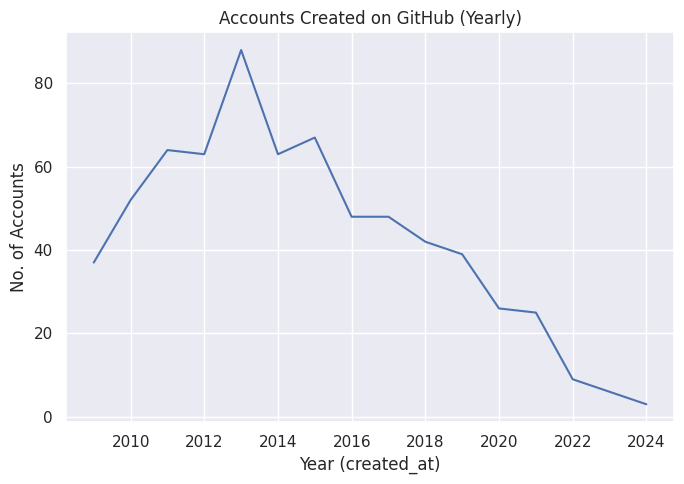

In [85]:
sns.lineplot(data=yearly_created_users)
plt.title('Accounts Created on GitHub (Yearly)')
plt.xlabel('Year (created_at)')
plt.ylabel('No. of Accounts')
plt.tight_layout()
plt.show()

Note: The number of accounts created in an year peeked in 2013, it is on a decline ever since.

### Average and Median Repo Stars by Language

In [86]:
popular_languages = repos_df.groupby('language')['stargazers_count'].median()
popular_languages

language
AGS Script          8.0
AMPL                2.0
ANTLR               0.0
API Blueprint       1.0
APL                 5.0
                   ... 
ZenScript           0.0
Zig                 0.0
mcfunction          2.5
q                   2.0
reStructuredText    1.0
Name: stargazers_count, Length: 213, dtype: float64

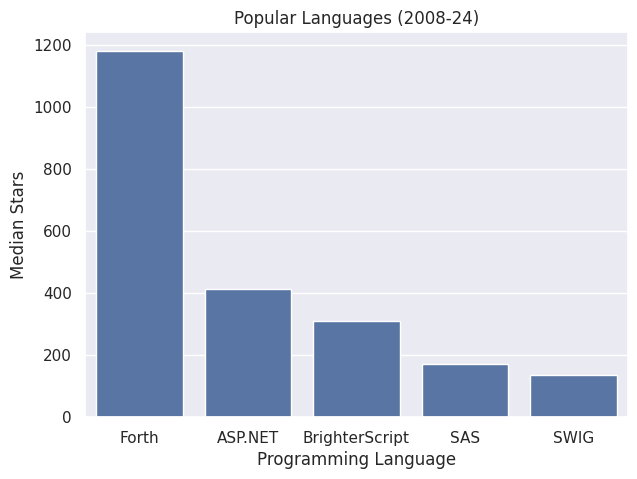

In [87]:
sns.barplot(data=popular_languages.nlargest(5))
plt.title('Popular Languages (2008-24)')
plt.xlabel('Programming Language')
plt.ylabel('Median Stars')
plt.show()

Note: Forth is the most popular programming language in Toronto.

### Correlation Analysis

In [88]:
users_df[['public_repos', 'followers', 'following', 'leader_strength']].corr()

,public_repos,followers,following,leader_strength
public_repos,1.000000,0.054894,0.014837,-0.001432
followers,0.054894,1.000000,0.007944,0.656162
following,0.014837,0.007944,1.000000,-0.040108
leader_strength,-0.001432,0.656162,-0.040108,1.000000


Note: No strong linear correlation among the numerical features.

### Pivot Table of License Usage by Language

In [89]:
repos_df.head()

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,aneagoie,aneagoie/ztm-extension,2023-12-15 13:32:57+00:00,3,3,JavaScript,True,False,mit
1,aneagoie,aneagoie/ML-Notes,2019-09-28 02:31:10+00:00,60,60,Jupyter Notebook,True,True,NaN
2,aneagoie,aneagoie/smart-brain-boost-api-dockerized,2018-04-12 18:44:49+00:00,55,55,JavaScript,True,True,NaN
3,aneagoie,aneagoie/smart-brain-boost-api,2018-04-09 18:46:06+00:00,14,14,JavaScript,True,True,NaN
4,aneagoie,aneagoie/smart-brain-boost-lambda,2018-04-15 17:02:27+00:00,20,20,JavaScript,True,True,NaN


In [90]:
popular_languages.nlargest(5).index.to_list()

['Forth', 'ASP.NET', 'BrighterScript', 'SAS', 'SWIG']

In [91]:
pivot_table = repos_df.pivot_table(index='license_name', columns='language', values='stargazers_count', aggfunc='mean')
pivot_table.mean(axis=0).nlargest(10)

language
Cython            1366.250000
BrighterScript     311.000000
MATLAB             268.521429
Jinja              218.777778
ShaderLab          184.277778
Dart               183.335100
Kotlin             181.852903
AppleScript        172.000000
SWIG               136.000000
Pawn               101.000000
dtype: float64

### Top Companies with High Leader Strength

In [92]:
users_df.groupby('company')['leader_strength'].mean().nlargest(10)

company
PROJECT NAYUKI                                    3541.000000
ATTALITECH LTD                                    2141.000000
VECTOR INSTITUTE                                  1292.000000
DEEP LEARNING CONSULTANT                          1125.500000
OLLAMA                                             980.000000
HAPI // SMILE CDR // UNIVERSITY HEALTH NETWORK     585.000000
HTTPS://FRONTENDSNACKS.DEV/                        523.000000
ANACONDA, INC.                                     407.000000
JACINTO DESIGN                                     377.000000
GITHUB                                             375.093333
Name: leader_strength, dtype: float64

In [93]:
users_df[users_df['company'] == 'OLLAMA']

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at,leader_strength
18,jmorganca,Jeffrey Morgan,OLLAMA,Toronto,jmorganca@gmail.com,False,Building @ollama \r\n\r\nPreviously at @docker...,2,1960,1,2010-04-24 05:02:15+00:00,980.0


### Repo Activity by Year

In [94]:
yearly_created_repos = repos_df.groupby(pd.Grouper(key='created_at', freq='YE'))['login'].count()
yearly_created_repos.head()

created_at
2008-12-31 00:00:00+00:00      79
2009-12-31 00:00:00+00:00     191
2010-12-31 00:00:00+00:00     516
2011-12-31 00:00:00+00:00     799
2012-12-31 00:00:00+00:00    1454
Freq: YE-DEC, Name: login, dtype: int64

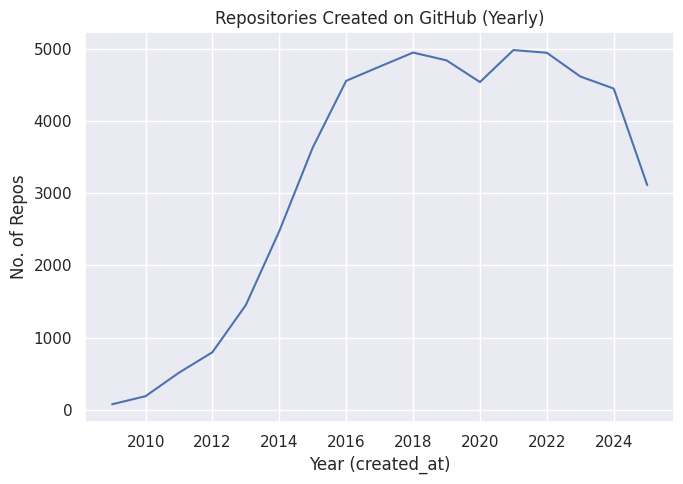

In [95]:
sns.lineplot(data=yearly_created_repos)
plt.title('Repositories Created on GitHub (Yearly)')
plt.xlabel('Year (created_at)')
plt.ylabel('No. of Repos')
plt.tight_layout()
plt.show()

Note: Sharp increase in number of repos being created in 2015.

### Repo Engagement Rates

In [96]:
popular_users = repos_df.groupby('login')['stargazers_count'].mean()
popular_users

login
0xsauby         85.571429
1997alireza      2.485714
1Computer1       8.296296
1Password      130.118421
32teeth          2.506667
                  ...    
zhangsu          2.137931
ziishaned      625.512195
zlovatt         12.214286
zoffixznet       0.116000
zoltan-nz        2.763780
Name: stargazers_count, Length: 678, dtype: float64

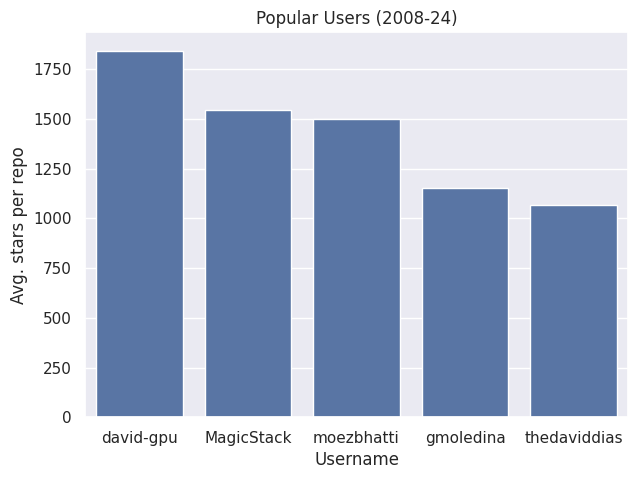

In [97]:
sns.barplot(data=popular_users.nlargest(5))
plt.title('Popular Users (2008-24)')
plt.xlabel('Username')
plt.ylabel('Avg. stars per repo')
plt.show()

Note: Suprising result as these aren't the most popular user nor have the highest no. of repos.

### Average Leader Strength by Repo Language

In [98]:
repos_df.groupby('language')['login'].unique()

language
AGS Script                                                [utiasASRL]
AMPL                                        [ReikaKalseki, shonfeder]
ANTLR                                 [jamesagnew, lextm, zoffixznet]
API Blueprint                                           [lunaroyster]
APL                                                      [codereport]
                                          ...                        
ZenScript                                                 [Krutonium]
Zig                 [wiseodd, zackradisic, gf3, DaleSeo, andrewn6,...
mcfunction                                     [fmoliveira, adryd325]
q                                                            [san089]
reStructuredText                                          [eviltrout]
Name: login, Length: 213, dtype: object

In [99]:
language_users = repos_df.groupby('language')['login'].unique()

avg_leader_strength = []

for i, users in zip(language_users.index, language_users):
    avg_leader_strength.append([i, users_df[users_df['login'].isin(users)]['leader_strength'].mean().round(4)])

avg_leader_str = pd.DataFrame(avg_leader_strength, columns=['language', 'avg_leader_strength'])
avg_leader_str.head()

,language,avg_leader_strength
0,AGS Script,162.0000
1,AMPL,189.8090
2,ANTLR,197.3832
3,API Blueprint,0.9469
4,APL,36.8542


In [100]:
avg_leader_str.nlargest(10, columns='avg_leader_strength')

,language,avg_leader_strength
67,Forth,1227.0000
129,PAWN,1227.0000
134,Pawn,1227.0000
178,Starlark,885.1463
72,Gleam,648.3333
96,KiCad,638.0000
118,Nginx,607.1315
131,PLSQL,589.0000
212,reStructuredText,589.0000
35,Clean,564.0000
